# Description

As a first step, we need to explore and preprocess our data. The goal of this step is to prepare the data for applying clustering algorithms. The dataset contains metadata for all 45,000 movies listed in the Full MovieLens Dataset. It consists of movies released on or before July 2017. Data points include title, posters, backdrops, budget, revenue, release dates, languages, description, production countries, and companies.

Source: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv

# Import libraries

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

plt.style.use('ggplot')
plt.close('all')

In [2]:
# This is done to avoid seeing warnings in Jupyter Notebook

import warnings
warnings.filterwarnings('ignore')

# Basic exploration and preprocessing

In [36]:
# load and check a few rows of movies metadata

df = pd.read_csv('../data/raw_data/movies_metadata.csv')

df.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


We see a lot of attributes that describe the movie. In this project, we are going to apply clustering algorithms on text data of the movie (overview), but also for clear clusters we take a genre of film so basically we need from this file three columns: its overview, genres and title.

In [37]:
# leave the necessary columns

df = df[['overview', 'genres', 'original_title']]

df.head()

,overview,genres,original_title
0,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story
1,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji
2,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men
3,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Waiting to Exhale
4,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II


We see that column genres it is list of dictinary with id's and names of genres. So we need to cleen that and leave only list of genres names

In [38]:
# cleaning the column of genres

def get_genres( item ):

    item = eval(item)  
    result = list( map( lambda x: x['name'], item ) )

    if result == []:
        return np.nan

    return result
    


df['genres'] = df['genres'].apply( get_genres )

In [39]:
df.head()

,overview,genres,original_title
0,"Led by Woody, Andy's toys live happily in his ...","[Animation, Comedy, Family]",Toy Story
1,When siblings Judy and Peter discover an encha...,"[Adventure, Fantasy, Family]",Jumanji
2,A family wedding reignites the ancient feud be...,"[Romance, Comedy]",Grumpier Old Men
3,"Cheated on, mistreated and stepped on, the wom...","[Comedy, Drama, Romance]",Waiting to Exhale
4,Just when George Banks has recovered from his ...,[Comedy],Father of the Bride Part II


We already have three columns - overview, genres and original_title. We need also two important columns that help us to create good recomendation system it is aktors and film director. Theese columns are important because people often watch films in which a famous director or actors they love appear.

In [40]:
# load and check data about aktors and film director of films

aktors_director = pd.read_csv('../data/raw_data/credits.csv')

aktors_director.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


So again we have columns of list of dictionary. From column cast we need all values where key is name (actual name of actor). From column cast we need only one value of name where value of key job is Director.

In [41]:
# get aktors

def get_aktors( item ):

    item = eval(item)  
    result = list( map( lambda x: x['name'], item ) )
    
    if result == []:
        return np.nan
    
    return result


df['aktors'] = aktors_director['cast'].apply( get_aktors )

In [42]:
# get director of film

def get_director( item ):

    item = eval(item)  
    necessary_item = list( filter( lambda x: x['job'] == 'Director', item) )

    if necessary_item == []:
        return np.nan
    
    return necessary_item[0]['name']


df['director'] = aktors_director['crew'].apply( get_director )

In [43]:
df.head()

,overview,genres,original_title,aktors,director
0,"Led by Woody, Andy's toys live happily in his ...","[Animation, Comedy, Family]",Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter
1,When siblings Judy and Peter discover an encha...,"[Adventure, Fantasy, Family]",Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston
2,A family wedding reignites the ancient feud be...,"[Romance, Comedy]",Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch
3,"Cheated on, mistreated and stepped on, the wom...","[Comedy, Drama, Romance]",Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker
4,Just when George Banks has recovered from his ...,[Comedy],Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer


Now we have all columns what we will need in this project.

In [44]:
# check the basic info about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overview        44512 non-null  object
 1   genres          43024 non-null  object
 2   original_title  45466 non-null  object
 3   aktors          43049 non-null  object
 4   director        44579 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


We see that columns overview, genres, aktors and director have null values, so we need to drop those lines.

In [45]:
# drop lines with null values

df.dropna(axis=0, inplace=True)

The column overview has null values, which are marked in the text and have no description. 

In [46]:
no_overview = [ 'No overview found.', 'No overview yet.', 'No Overview', 'No movie overview available.', 'No plot overview available' ]
df = df[ ~df['overview'].isin(no_overview) ]

In [47]:
# check data info after cleaning

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39774 entries, 0 to 45463
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overview        39774 non-null  object
 1   genres          39774 non-null  object
 2   original_title  39774 non-null  object
 3   aktors          39774 non-null  object
 4   director        39774 non-null  object
dtypes: object(5)
memory usage: 1.8+ MB


# Text preprocessing

So we have the necessary data columns without null values. Now we need to prepare our text data. It contains: unify text, leave only alphabetic symbols, remove unnecessary spaces, tokenization, remove stop words, stemming.

In [48]:
# convert text to lowercase 

df['overview'] = df['overview'].str.lower()

In [49]:
# text cleaning 

def clean( text ):

    text = text.strip()

    available_symbols = "abcdefghijklmnopqrstuvwxyz "
    cleaned_text = [s for s in text if s in available_symbols]
    cleaned_text = ''.join(cleaned_text)
    
    while '  ' in cleaned_text:
        cleaned_text = cleaned_text.replace('  ', ' ')
    
    return cleaned_text


df['overview'] = df['overview'].apply( clean )

In [50]:
# tokenization and removing stop words

def remove_stop_words( text, sw ):

    tokens = text.split()
    tokens = [ token for token in tokens if token not in sw ]

    return tokens


sw = stopwords.words('english')
df['overview'] = df['overview'].apply( lambda text: remove_stop_words( text, sw ) )

In [51]:
# stemming

def stem( tokens, stemmer ):

    return [ stemmer.stem( token ) for token in tokens ]


stemmer = PorterStemmer()
df['overview'] = df['overview'].apply( lambda tokens: stem( tokens, stemmer ))

In [52]:
# check text data

df.head()

,overview,genres,original_title,aktors,director
0,"[led, woodi, andi, toy, live, happili, room, a...","[Animation, Comedy, Family]",Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter
1,"[sibl, judi, peter, discov, enchant, board, ga...","[Adventure, Fantasy, Family]",Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston
2,"[famili, wed, reignit, ancient, feud, nextdoor...","[Romance, Comedy]",Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch
3,"[cheat, mistreat, step, women, hold, breath, w...","[Comedy, Drama, Romance]",Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker
4,"[georg, bank, recov, daughter, wed, receiv, ne...",[Comedy],Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer


# Text data analysis

We already have cleaned our text data, so we need to explore basic information about them.

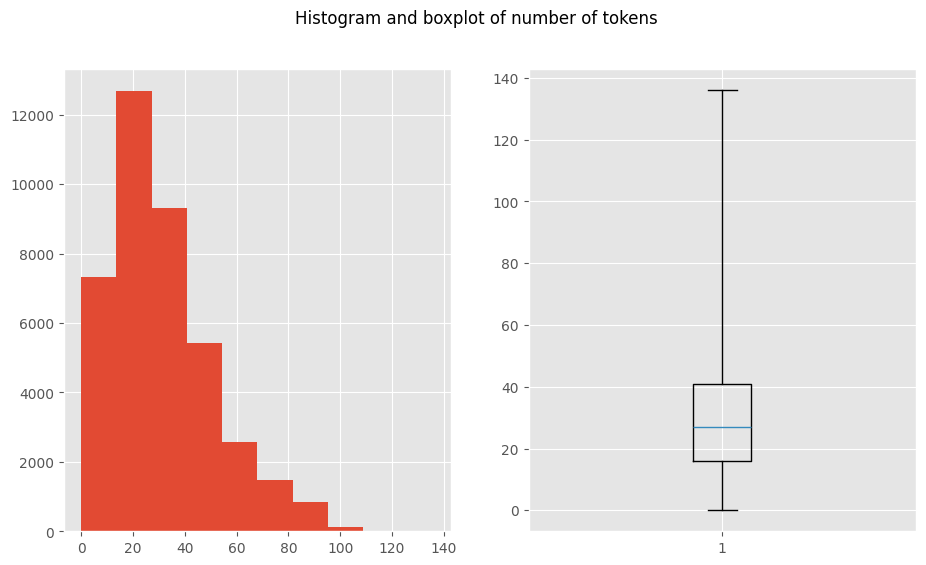

In [53]:
# count tokens histogram and boxplot 

df['count_tokens'] = df['overview'].apply( lambda tokens: len( tokens ) )


plt.figure( figsize=(11, 6) )
plt.suptitle('Histogram and boxplot of number of tokens')

plt.subplot(1, 2, 1)
plt.hist( df['count_tokens'] )

plt.subplot(1, 2, 2)
plt.boxplot( df['count_tokens'], whis=(0,100) )

plt.show()

We see that the median is ~27 tokens, and the majority of data has a count of tokens between 0 and 60. So we will observe in the feature how it influences clustering and whether this number of words in the film description will be sufficient to break down the data into clear clusters.

In [54]:
# number of unique words

texts = df['overview'].values.tolist()

unique_words = set()
for text in texts:
    for word in text:
        unique_words.add( word )

print(f'Number of unique words in data: {len(unique_words)}')

Number of unique words in data: 60661


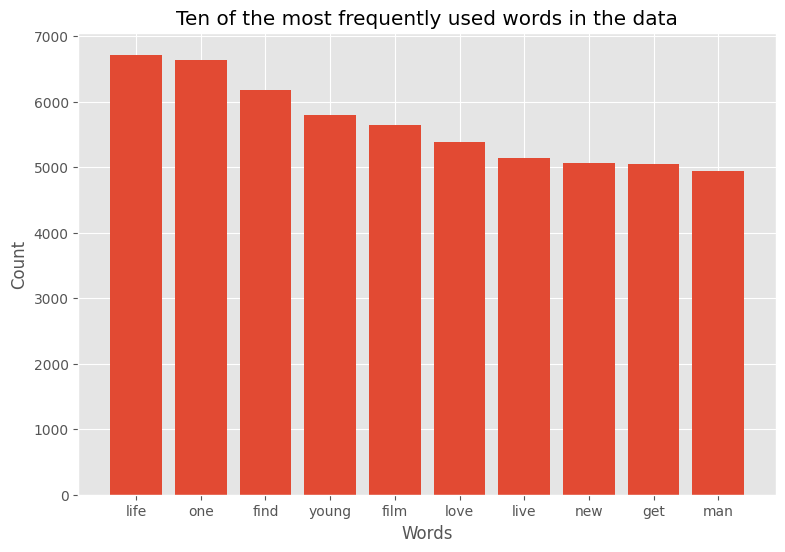

In [55]:
# top 10 most frequently used words

words_dictionary = {}

for text in texts:
    for word in text:

        if word not in words_dictionary:
            words_dictionary[word] = 0

        words_dictionary[word] += 1

sorted_words = sorted( words_dictionary.items(), key=lambda x: x[1], reverse=True )
most_frequently = dict(sorted_words[:10])

plt.figure( figsize=(9, 6) )
plt.bar(most_frequently.keys(), most_frequently.values())
plt.title('Ten of the most frequently used words in the data')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()


We see that the most frequent words don't give general information about the film; all of them are words that can appear in any film description. So in the vectorization step, using TfidfVectorizer will be better than the common CountVectorizer.

# Anlysis of other columns

We have analysed overview column, so we are going to analyze othe columns - genres, aktors and director.

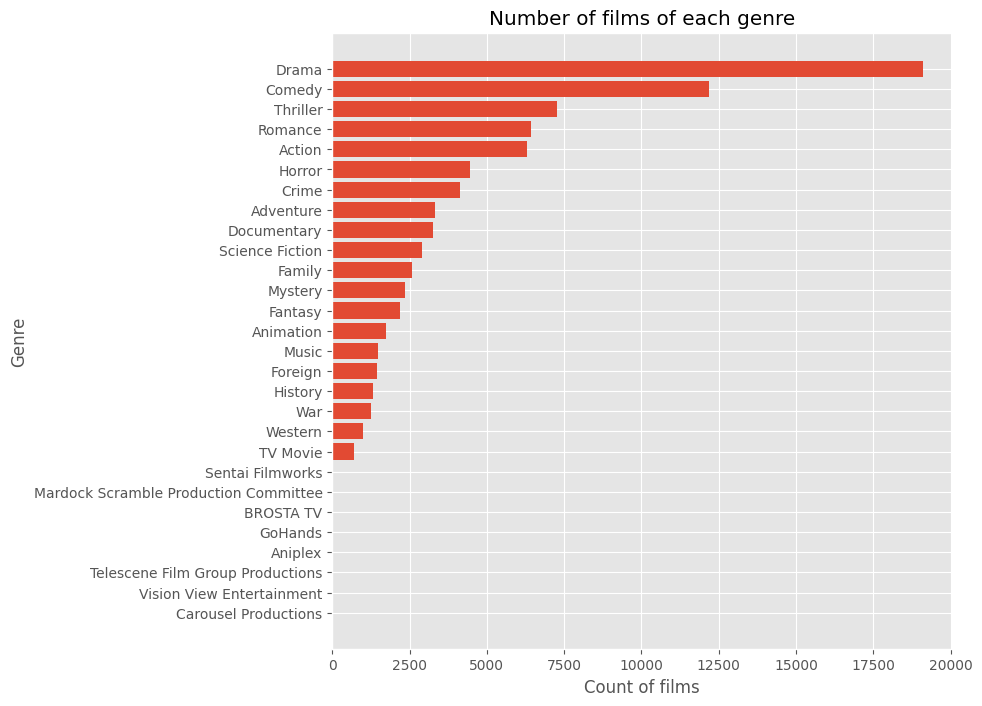

In [83]:
# number of films of each genre

genres_dictionary = {}

for genres in df['genres'].values:
    for genre in genres:

        if genre not in genres_dictionary:
            genres_dictionary[genre] = 0

        genres_dictionary[genre] += 1

sorted_genres = dict( sorted( genres_dictionary.items(), key=lambda x: x[1]) )

plt.figure( figsize=(8, 8) )
plt.barh( sorted_genres.keys(), sorted_genres.values() )
plt.xlabel('Count of films')
plt.ylabel('Genre')
plt.title('Number of films of each genre')
plt.show()

We see that the most frequently genres are drama and comedy, so we can expect that recomendation for film from theese clusters will be well. Also we see that data have 8 genre that actually are not genres, so for now, we will not delete the lines with these genres; we will see whether this will cause any problems during modeling or not.

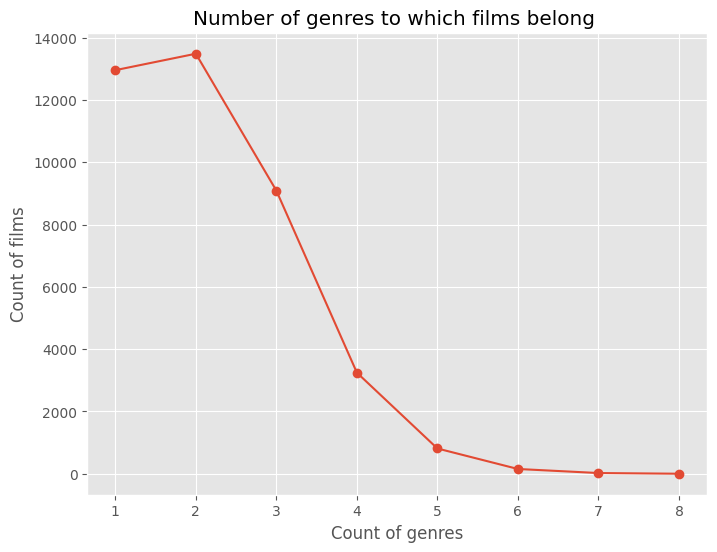

In [88]:
# number of genres to which films belong 

number_genres = df['genres'].apply( lambda x: len(x) )
number_genres = number_genres.value_counts().sort_index()

plt.figure( figsize=(8, 6) )
plt.plot( number_genres.index, number_genres.values, marker='o' )
plt.xlabel('Count of genres')
plt.ylabel('Count of films')
plt.title('Number of genres to which films belong ')
plt.show()

We see that a lot of film belong to 2, 3, or 4 genres, so we expect that clusters will be a pretty not clear.

In [ ]:
# number of aktors in films



In [ ]:
# top 10 directors by number of films 

# Text vectorization

Before applying any machine learning algorithms, we should convert text data to numbers. Based on the previous analysis, we are going to use TfidfVectorizer, which takes into account the frequency of words in the data.

In [17]:
# vectorization of text

vectorizer = TfidfVectorizer()
vec_text_data = vectorizer.fit_transform( df['overview'].apply( lambda x: ' '.join(x) ) )

In [18]:
print(f'Shape of vectorizated text: {vec_text_data.shape}' )

Shape of vectorizated text: (44366, 65725)


# Reduction of dimensionality

Now we have a matrix with a huge shape, that has more features than data lines. So we need to reduce dimensionality before applying clustering algorithms. We are going to use one of the most common methods - PCA (Principal Component Analysis).

In [19]:
# applying reduction of dimensionality

pca = PCA( n_components=50 ).set_output(transform='pandas')
reduced_data = pca.fit_transform( vec_text_data )

In [20]:
# add a title column and overview for future using

reduced_data['title'] = df['original_title'].values
reduced_data['overview'] = df['overview'].values

In [21]:
reduced_data.head(3)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49,title,overview
0,0.017633,-0.007924,-0.015550,0.000302,0.000365,-0.022049,0.002591,-0.008464,-0.010561,0.002480,...,-0.001091,0.008336,0.004997,0.005294,0.004412,0.008469,0.000249,-0.009911,Toy Story,"[led, woodi, andi, toy, live, happili, room, a..."
1,0.001098,-0.027537,-0.040712,0.044191,0.015212,0.030396,0.029333,0.035673,-0.005655,0.020995,...,0.031742,-0.003428,-0.026673,-0.005241,-0.027287,-0.014400,-0.029571,-0.021927,Jumanji,"[sibl, judi, peter, discov, enchant, board, ga..."
2,-0.005981,-0.017038,-0.026429,0.009457,-0.029082,-0.052522,-0.026780,-0.027246,-0.020376,0.003065,...,-0.015675,0.011839,0.007691,0.014303,-0.018292,-0.013140,-0.004403,-0.008304,Grumpier Old Men,"[famili, wed, reignit, ancient, feud, nextdoor..."


In [22]:
# save preprocessed data

reduced_data.to_csv('../data/preprocessed_data.csv', index=False)